In [1]:
import tensorflow as tf
import numpy as np 
from cvae import *
import h5py
from scipy.spatial.distance import jensenshannon
tf.__version__
# tf.executing_eagerly()


'2.2.0'

In [2]:
# ------------- __init__ ------------------
vae = VariationalAutoEncoder(input_shape=(512,512,1), latent_dim=32) # model
print(vae)
# base_model = tf.keras.applications.ResNet50(input_shape=(512,512,1), include_top=False, weights=None)
# vae.create_encoder(base_model)
vae.create_encoder()
vae.create_decoder()
vae.load_weights('vae.h5')
vae.build(input_shape=(None,512,512,1))
# vae.base_model.summary()
# vae.encoder.summary()
# vae.decoder.summary()
vae.summary()

512 16 5
Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base_model (Model)           (None, 16, 16, 80)        92544     
_________________________________________________________________
encoder (Model)              (None, 32)                1403328   
_________________________________________________________________
decoder (Model)              (None, 512, 512, 1)       870273    
Total params: 2,273,601
Trainable params: 2,273,601
Non-trainable params: 0
_________________________________________________________________


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
def plot_latent_images(model, n, digit_size=512):
  """Plots n x n digit images decoded from the latent space."""

#   norm = tfp.distributions.Normal(0, 1)
  norm = np.random.normal(0, 1)
  grid_x = np.linspace(-3, 3, n)
  grid_y = np.linspace(-3, 3, n)
#   grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
#   grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))
  latent_dim = model.latent_dim

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.ones((1, latent_dim))
      z[0,0] = xi
      z[0,1] = yi
#       z[0,2] = xi
#       z[0,3] = yi
#       z = np.array([[xi, yi, 1.5, 1.5]])
      x_decoded = model.decoder(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(20, 20))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

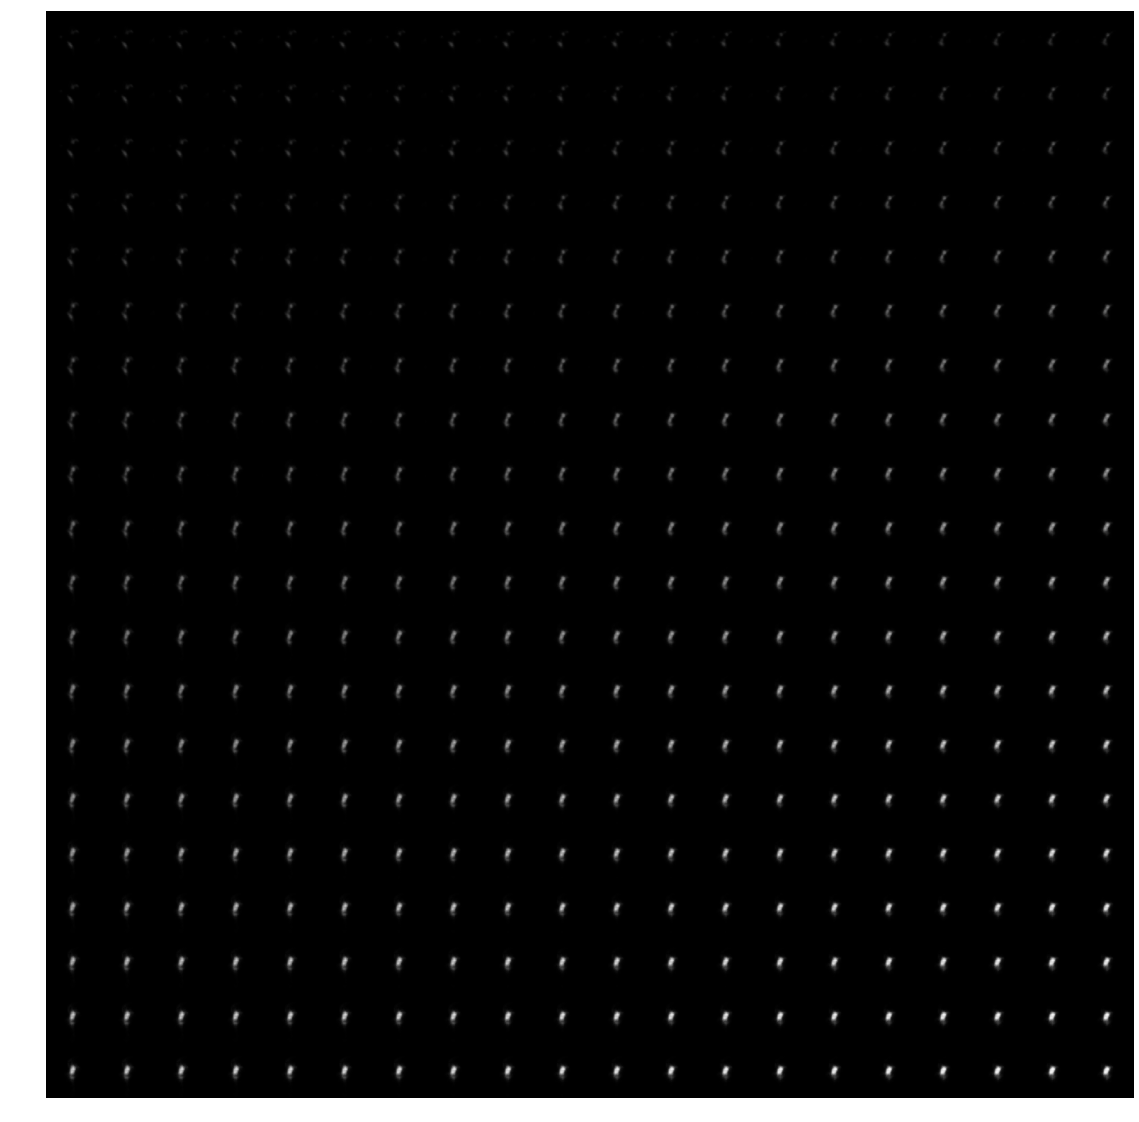

In [4]:
plot_latent_images(vae, 20)

(35784, 32)


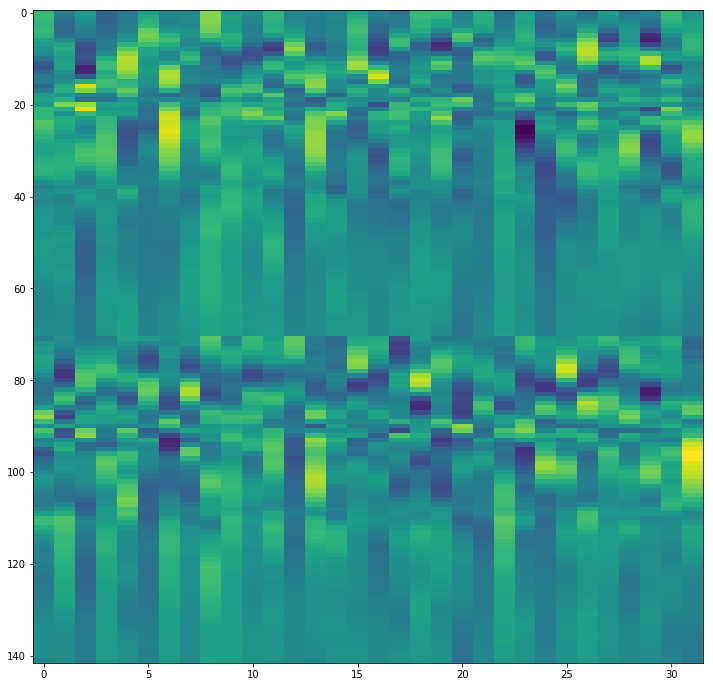

In [5]:
with h5py.File('encoded_train_images.h5', 'r') as h5f:
    enc_train = h5f['encoded'][()]
    print(enc_train.shape)
plt.figure(10, figsize=(12,12))
plt.imshow(enc_train[:142,:].astype(np.float32), aspect='auto')
plt.show()

In [6]:
# --------------- predict --------------------

def find_similar_images(model, query_img_array, query_img_id, k=5):
    enc_test = model.encoder.predict(query_img_array)
    print(np.array(enc_test).shape)
    enc_dist = tf.norm(enc_test[query_img_id] - enc_train, axis=-1)
    enc_dist_unique, enc_dist_unique_id = np.unique(enc_dist, return_index=True)
    print('enc_train', enc_train.shape, enc_train[enc_dist_unique_id[0]])
    decoded_image = model.decoder.predict(enc_train[enc_dist_unique_id[0]].reshape(1,32))
    print(decoded_image.shape)
#     print(enc_dist_unique_id)
#     print(enc_dist_unique)
    panel_size = 12
    
#     neighbors = tf.argsort(enc_dist)
#     print(neighbors)
#     print(tf.sort(enc_dist)[k:])
    plt.figure(11)
    orig_img = query_img_array[query_img_id]
    decoded_img = decoded_image[0]
    mae_dist = tf.keras.losses.MAE(orig_img, decoded_img).numpy()[0]
    orig_img_tf = tf.image.convert_image_dtype(orig_img, tf.float32)
    decoded_img_tf = tf.image.convert_image_dtype(decoded_img, tf.float32)
    ssim_dist = tf.image.ssim(orig_img_tf, decoded_img_tf, max_val=1.0)
    
    ax = plt.subplot(1, 2, 1)
    ax.imshow(query_img_array[query_img_id][:, :, 0])
    ax.set_title('obs')
    ax = plt.subplot(1, 2, 2)
    ax.imshow(decoded_image[0, :, :, 0])
    ax.set_title('rec, %.2f' % ssim_dist)
    
    # calculate JS distance
#     print('dist', tf.keras.losses.MAE(query_img_array[query_img_id][:, :, 0].flatten(), decoded_image[0, :, :, 0].flatten()))

#     plt.figure(12, figsize=(panel_size, (k+1)*panel_size))

#     for i in range(1, k+1):
#         ax = plt.subplot(1, k, i)
#         ax.imshow(train_images[enc_dist_unique_id[i]][:, :, 0])
#         ax.set_title('%d, %.2f' % (enc_dist_unique_id[i], enc_dist_unique[i]))
    plt.show()
    plt.tight_layout()

In [7]:
# ------- preprocessing -----------
import glob
import cv2
import os 

img_list = glob.glob('../DeepGalaxy/validation_images/*.jpg')
print(img_list)
img_size = 512

obs_imgs = []
obs_imgs_title = []
for img_name in img_list:
    im = cv2.imread(img_name)
    im_grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im_resized = cv2.resize(im_grey, (img_size,img_size))
    print(img_name, im_resized.shape)
    obs_imgs.append((im_resized.reshape(img_size,img_size,1)/255).astype(np.float32))
    obs_imgs_title.append(os.path.basename(img_name))
print(obs_imgs_title)
obs_imgs = np.array(obs_imgs)

['../DeepGalaxy/validation_images/hst_arp142.jpg', '../DeepGalaxy/validation_images/hst_arp148.jpg', '../DeepGalaxy/validation_images/hst_arp188.jpg', '../DeepGalaxy/validation_images/hst_arp194.jpg', '../DeepGalaxy/validation_images/hst_arp240_ngc_5257.jpg', '../DeepGalaxy/validation_images/hst_arp256.jpg', '../DeepGalaxy/validation_images/hst_arp273.jpg', '../DeepGalaxy/validation_images/hst_arp293_ngc6285_ngc6286.jpg', '../DeepGalaxy/validation_images/hst_arp87.jpg', '../DeepGalaxy/validation_images/hst_ic2163_ngc2207.jpg', '../DeepGalaxy/validation_images/hst_ngc2623.jpg', '../DeepGalaxy/validation_images/hst_ngc4038_ngc4039.jpg', '../DeepGalaxy/validation_images/hst_ngc4676.jpg', '../DeepGalaxy/validation_images/hst_ugc8335_arp238.jpg']
../DeepGalaxy/validation_images/hst_arp142.jpg (512, 512)
../DeepGalaxy/validation_images/hst_arp148.jpg (512, 512)
../DeepGalaxy/validation_images/hst_arp188.jpg (512, 512)
../DeepGalaxy/validation_images/hst_arp194.jpg (512, 512)
../DeepGalaxy/va

In [8]:
enc_test = vae.encoder.predict(obs_imgs)

(14, 32)
enc_train (35784, 32) [-1.2981788   0.5703624  -0.64917445  0.753603    0.3963102  -0.4506193
 -3.748376    0.01054297  0.87803537  0.9974828   0.9927542   1.6374313
 -1.6004404   0.9120049   0.20877963  1.2557253   0.20922099 -2.7969162
 -1.2246385  -2.6654425   1.0267384  -0.14044684  0.5476549  -0.01143176
  1.5262167   2.4987319  -0.5020098   1.4571435  -1.054297   -0.4178827
  0.06415189  0.66352856]
(1, 512, 512, 1)


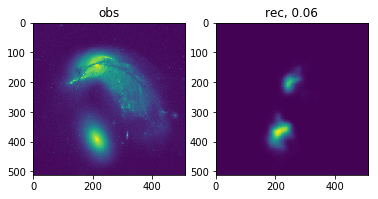

(14, 32)
enc_train (35784, 32) [ 1.2082778   1.0602975  -2.0594628  -0.9683209  -0.21746781 -0.8072434
 -1.2800623   0.02196425 -1.1268655   0.886029   -0.4596621   0.9389009
 -1.6549102  -1.6709194   0.497735    0.00440787 -0.6071586  -0.30317345
  0.97906286  1.2579871   3.0967488  -1.5191798   1.1237763   1.7325763
 -0.84897727  0.39716431 -1.1390404  -0.21922156  1.5664471   0.1402124
  1.4551069   0.6205331 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

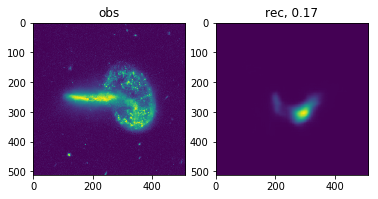

(14, 32)
enc_train (35784, 32) [-0.25145024 -0.52851117  0.20010954 -1.2491115  -0.8193873   0.1730505
  0.13463457  1.7648056  -1.4545959   0.41231072  2.2715626   0.62470675
  0.61243534 -0.5597442  -1.1403445   0.10348392 -1.0468372  -1.3802439
  0.6214464   0.65994453 -0.72712785  0.48856562 -0.36727992  0.8251325
 -0.1263219   1.2668558  -0.61473286 -0.80545145 -1.2631279   1.0258292
 -0.7684623  -0.6329789 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

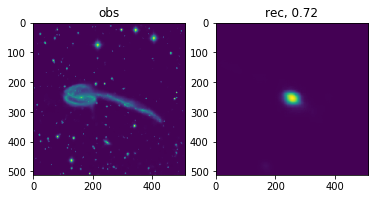

(14, 32)
enc_train (35784, 32) [-1.3036973e+00  5.7996684e-01 -6.4068508e-01  7.7338248e-01
  3.9578405e-01 -4.3122786e-01 -3.7600310e+00  3.6297385e-03
  8.6858213e-01  9.8250401e-01  1.0192029e+00  1.6254083e+00
 -1.5864904e+00  8.9888173e-01  1.9212550e-01  1.2789192e+00
  2.2281627e-01 -2.7970972e+00 -1.2294354e+00 -2.6848102e+00
  1.0283588e+00 -1.4370556e-01  5.6096774e-01 -5.0811758e-03
  1.5774366e+00  2.4826303e+00 -5.0782543e-01  1.4168910e+00
 -1.0789063e+00 -4.2132160e-01  6.9383994e-02  6.7407489e-01]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

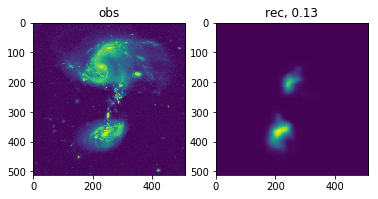

(14, 32)
enc_train (35784, 32) [ 0.8955352   0.07024755 -0.2025714  -0.11271086 -1.2353642  -1.3876234
  1.3534589   0.2432603   0.38507703  1.1514564   0.07751506  0.22208169
 -1.0632465  -0.03775668  0.42145982 -1.5850259  -0.57794434  0.24392448
 -0.21984331 -0.08559354  3.3770437  -1.4116763   1.5194627  -0.12103716
 -0.80488265 -1.9999382  -0.56002414  0.42050514 -0.87671906  0.7965659
 -1.3009278   0.0550913 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

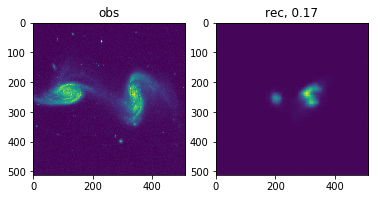

(14, 32)
enc_train (35784, 32) [-0.61749697 -0.0755805   2.4947646  -1.2222992   0.5972996  -0.84390247
 -0.711304    0.44183728  4.0993843   1.2411425   2.6148632  -0.7346826
 -2.1280103   0.15593706 -0.58872813 -0.74074095 -0.3624246   0.08693356
  0.2357025  -0.5736031   2.9749625  -0.9732575   1.3252025   0.3899573
 -2.0890436  -0.31440678  1.3895625   0.538807   -0.6515394   0.22910549
 -0.4524467   1.5120873 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

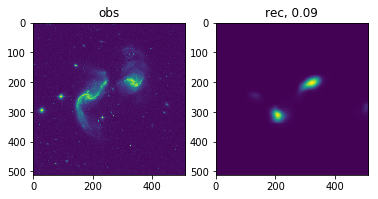

(14, 32)
enc_train (35784, 32) [-1.066478   -0.86785483 -0.95995134 -0.07411876  0.38341635 -0.6557392
 -1.7952275  -0.18500166 -1.8761604   1.0773907  -0.26888463  2.0835063
 -1.8053887   0.03827151  0.6380231   0.9830238  -0.49867064 -2.5759838
 -0.04799491 -1.5774964   4.754332   -1.2349637   1.3482352  -0.53065634
  1.5045716   2.0919006  -2.3116834   0.910586    0.49926686  0.30162194
  0.6751016   1.1034713 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

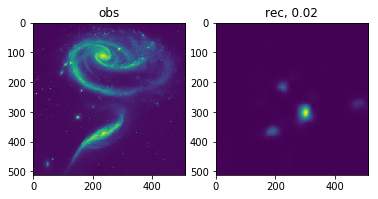

(14, 32)
enc_train (35784, 32) [-0.6749822  -2.4950109  -3.9042828  -0.8520107  -0.5419632   3.0202975
  0.05222318  0.41547412  2.3767514  -0.96870273 -0.41582054  2.218863
 -0.30017933 -1.1034025   0.7472899   3.4871147  -2.9313052  -0.19054294
 -0.2547337   3.3195162  -1.3839358  -0.3645355   1.1829599   0.732517
  0.7716383  -2.2542143   1.7444283  -0.94584495 -0.7339447  -0.8190972
  0.81235886 -0.01369935]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

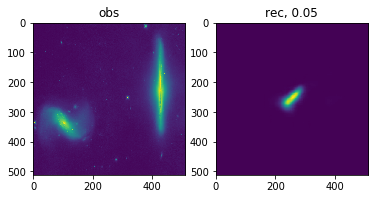

(14, 32)
enc_train (35784, 32) [-1.0904373  -1.6497053  -0.98672545 -0.2803897  -0.9278495   1.2088888
 -2.2931101   0.50025725  0.7396677  -0.862889   -0.69980645 -1.3160391
  0.3229557  -0.8730513   1.0537755   2.883309   -2.908307   -0.42792046
 -0.7236783   5.505306   -0.701465   -0.8902759   1.5997807   1.2856929
  0.9416607  -2.181051   -0.81938124  1.7835884  -1.1615481   2.6674385
  1.2460724  -0.5028265 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

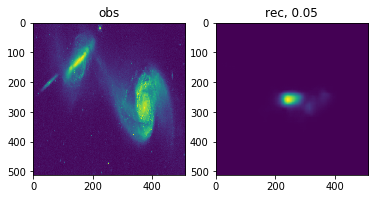

(14, 32)
enc_train (35784, 32) [-1.1597797  -0.9937409   0.4552705  -0.23874642 -0.58792883  0.35292643
 -2.9240386   0.43433505  0.04000534 -0.65007603 -0.8413664  -2.4708202
  1.2045184  -0.6860659   1.0450811   1.8249608  -2.4071162  -0.29815954
 -0.91241956  4.688467    0.04228532 -0.4751584   1.5316961   0.84649277
  0.8604436  -1.4446713  -1.2069461   3.0541868  -0.9224476   3.9031951
  1.0513924  -0.7179509 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

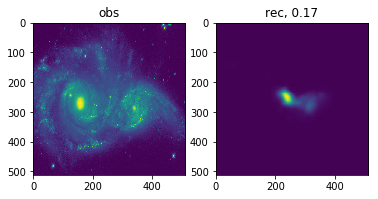

(14, 32)
enc_train (35784, 32) [ 0.52783024 -0.03497947 -0.29287285 -1.9696941  -0.6502995  -0.30854073
  0.1597642   1.4418887  -1.5176249   0.06711869  3.114628    0.755941
  1.1533223  -0.5442039  -1.9154425  -0.30296004 -0.9810835  -1.3506366
  0.16563128  0.9855736  -0.5567705   0.45767623 -0.5319302   0.7814833
 -0.05040799  1.0320877  -0.81823415 -0.9445681  -1.4543746   0.77465737
 -0.40488037 -0.13706663]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

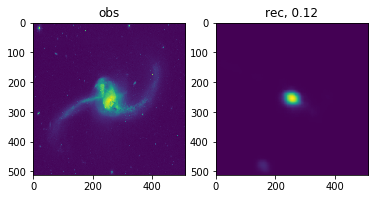

(14, 32)
enc_train (35784, 32) [-0.62327254 -3.0016143   0.11426993 -0.414141    1.0048897  -1.0261999
 -2.04716     0.39810172  1.7512008   0.9097114   1.0924699  -1.679659
 -1.6702048   0.40909848 -0.16668147 -0.46492404  0.7077942  -1.9243939
 -0.18870033 -1.0471177   3.775827   -1.0726607   1.6870621  -0.92614585
 -0.52986735  0.16261289 -1.614217    0.06412265 -0.5228812   0.41408196
  0.36527902  2.6818998 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

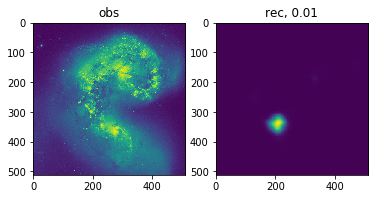

(14, 32)
enc_train (35784, 32) [ 1.961946   -0.25332978 -1.2435141   0.6717092  -0.76964617 -0.13058603
  1.6190093   1.3352761   2.3613126  -0.17996937 -2.701231    0.15341796
  0.16617762  3.321702    0.9263422   1.1913593  -2.2664514  -0.39660877
  1.9463665   0.2907682  -1.0843385  -0.6668948   0.32782093  0.6292279
 -2.229813   -0.39079523  0.54094785  0.08322626  3.1644113   0.01700858
  0.01298019  5.5511036 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

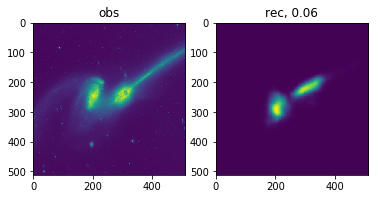

(14, 32)
enc_train (35784, 32) [ 0.2397682   0.1637741   0.2400206   0.88730896 -0.6472795   0.44513002
 -4.8157296   1.44309     0.59700197  0.72455543 -0.00745853  0.16781218
 -1.4487748   1.5935515  -0.21146064  1.048816   -0.98775315 -0.98839736
  0.58317673 -2.728903    0.55653757 -1.1300304   0.58027786  0.40179193
  0.25136203  1.1649197  -0.19645214  1.8776052  -0.6751369   0.64250875
 -1.0529288   3.6903563 ]
(1, 512, 512, 1)


<Figure size 432x288 with 0 Axes>

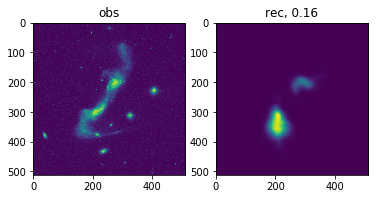

<Figure size 432x288 with 0 Axes>

In [9]:
for i in range(obs_imgs.shape[0]):
    find_similar_images(vae, obs_imgs,i, k=6)